# Multi Modal Brain tumor semantic segmentation using UNet as Baseline and ResNet + VAE for improvement

# **Installing dependecies** 📥

In [1]:
!python -c "import monai" || pip install -q "monai[nibabel, tqdm ,einops]"
!python -c "import matplotlib" || pip install -q matplotlib


!apt -y update
%pip install git+https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer.git
%pip install colorama
%pip install wandb
%pip install torchview
%pip install timm
%pip install torchinfo
%pip install nibabel
%pip install captum

%matplotlib inline

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Hit:3 https://deb.nodesource.com/node_16.x focal InRelease                     
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease           
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Fetched 336 kB in 1s (342 kB/s)    
Reading package lists... Done
Building dependency tree       
Reading state information... Done
141 packages can be upgraded. Run 'apt list --upgradable' to see them.
  Cloning https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer.git to /tmp/pip-req-build-rpt6l93r
  Running command git clone --filter=blob:none --quiet https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer.git /tmp/pip-req-build-rpt6l93r
  Resolved https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer.git to commit c82a3

# **Import dependecies 📑**

In [2]:
import os
import shutil
import tempfile
import time
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt


from colorama import Fore, Back, Style
g_ = Fore.GREEN
c_ = Fore.CYAN
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

#Optims
from ranger import Ranger



from models import ResNet3dVAE, ResNet3d, build_model, get_optimizer, get_scheduler
from utils import Visualizer, DatasetTransforms

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.utils import set_determinism

import torch
import torch.nn as nn
import numpy as np

import json
import wandb

In [3]:
#Config class for hyper params and model construction

cur_time = datetime.now().strftime('%Y%m%d_%T').replace(":", "")

class Config(nn.Module):
    def __init__(self , max_epochs=42, batch_size=1, lr=1e-4, \
                scheduler=None, wd=0.0, backbone=None, optim="ranger", arch = "SegResNet", loss="dice", swa=False, grad_acc=4, task='brain', val_interval=3,momentum=0.9, resume=False, comment=None, n_iters=19400):
        self.exp_name       = cur_time + "_"+ str(arch)+ "_"+ str(max_epochs) + "_"+ str(batch_size) + \
                            "_"+ str(lr) + "_"+ str(wd) + "_"+ str(backbone) + "_"+ str(optim)  + "_"+ str(loss)+ "_TASK: " + str(task) +" _RESUME:"+str(resume) + "Comment:"+str(comment)
        self.loss = loss
        self.optim          = optim
        self.max_epochs     = max_epochs
        self.batch_size     = batch_size
        self.lr             = lr
        self.scheduler      = scheduler
        self.wd             = wd
        self.backbone       = backbone
        self.device         = "cuda" if torch.cuda.is_available() else "cpu"
        self.seed           = 42
        self.data_dir       = "/notebooks/shared/data"
        self.min_lr         = 1e-6
        self.T_max          = int(30000/batch_size* max_epochs)+50
        self.T_0            = 25
        self.n_accumulate   = max(1,64/batch_size)
        self.n_fold         = 5
        self.num_classes    = 3
        self.arch           = arch
        self.swa            =swa
        self.grad_acc       =grad_acc
        self.task           = 'Task01_BrainTumour'
        self.val_interval   = val_interval
        self.momentum       = momentum
        self.resume         = resume
        self.comment        = comment
        self.n_iters        = (388/batch_size)*max_epochs

# Setting up Training Configuration ⚙️

In [4]:
cfg = Config(
    arch = "nnUNet",
    loss="CEDice",
    optim="ranger",
    batch_size=2,
    lr= 0.01,
    momentum = .99,
    max_epochs=37,
    scheduler=None,
    grad_acc=1,
    task = 'brain',
    resume = True,
    comment="testing",
    wd=0.05

)
print("Used device :", cfg.device)
print("Exp name :", cfg.exp_name)
print(f"Is training resumed : {cfg.resume}")

Used device : cuda
Exp name : 20230512_091134_nnUNet_37_2_0.01_0.05_None_ranger_CEDice_TASK: brain _RESUME:TrueComment:testing
Is training resumed : True


In [5]:
directory = cfg.data_dir
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/notebooks/shared/data


In [6]:
set_determinism(seed=cfg.seed)

**Initialize Weights and Biases API for tracking experiment**

In [7]:
wandb.login(key="WANDB_API_KEY")
# Initialize W&B run
run = wandb.init(project='brats_experiments_actual', 
                 config=cfg.__dict__,
                 group=f'{cfg.arch}_{cfg.optim}', 
                 job_type='train')

wandb: Currently logged in as: kevinye (ky_thesis). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Define helper functions for building model with sweep

**Data Preproccessing and Tranformations**

In [8]:
T = DatasetTransforms(cfg.task)
train_transform, val_transform = T.get_transforms("nnUnet")

# **Getting Dataset and Dataloaders 💾**

In [9]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task=cfg.task,
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task=cfg.task,
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=4, pin_memory=True)

image shape: torch.Size([4, 128, 128, 128])


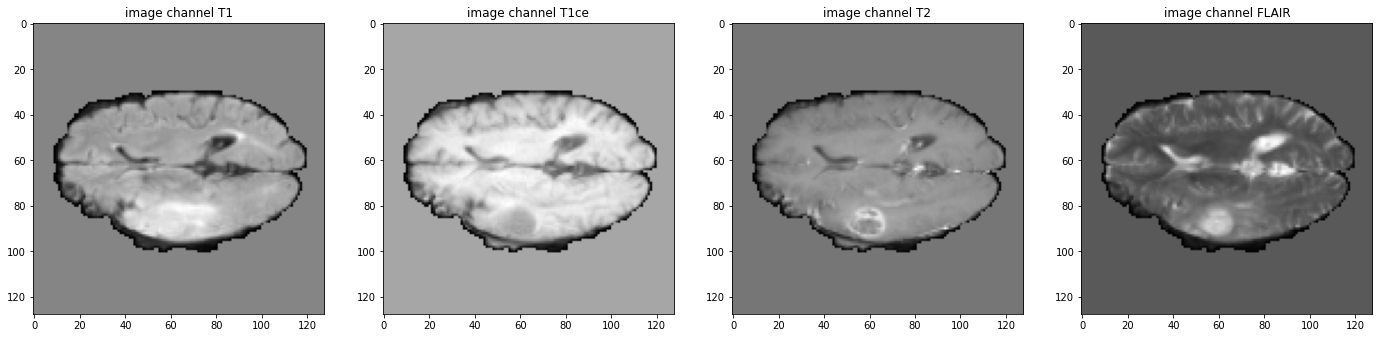

label shape: torch.Size([3, 128, 128, 128])


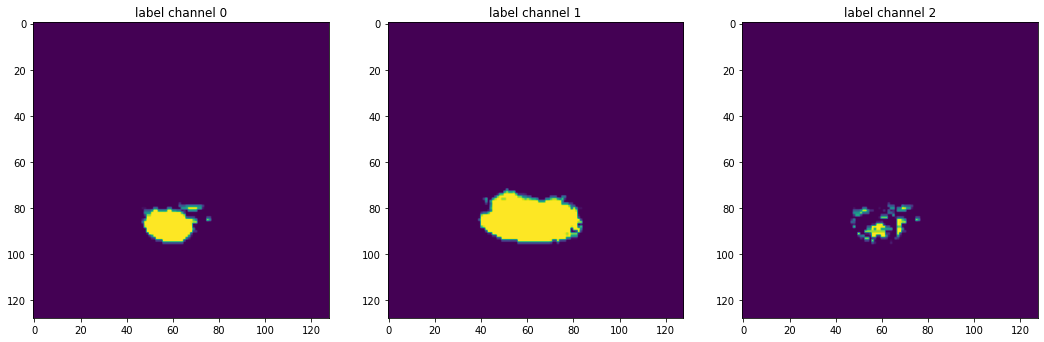

In [10]:
viswiz = Visualizer(4, 3, val_ds[2])
viswiz.plot()


# **Loading the Model** 🛠️

In [11]:
model = build_model(arch=cfg.arch, num_classes=cfg.num_classes, in_channels=4)
optimizer = get_optimizer(model, optim=cfg.optim, cfg=cfg)
lr_scheduler = get_scheduler(optimizer, cfg)
print(cfg.arch)
model

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
nnUNet


DynUNet(
  (input_block): UnetBasicBlock(
    (conv1): Convolution(
      (conv): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (conv2): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  )
  (downsamples): ModuleList(
    (0): UnetBasicBlock(
      (conv1): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (conv2): Convolution(
        (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
      (norm1): InstanceNorm3d(64, eps=1e-05, 

In [12]:
import torch.nn.functional as F
from monai.transforms import Compose, Activations, AsDiscrete

VAL_AMP=True

def loss_function_vae(dec,x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    mse_loss = nn.MSELoss(reduction = 'mean')
    MSE = mse_loss(dec, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return 0*MSE + 0.1*KLD
def log_cosh(loss_fn): 
    return torch.log(torch.cosh(loss_fn))

if cfg.loss == "Dice":
    loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
elif cfg.loss == "CEDice":
    loss_function = DiceCELoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")


post_trans = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)

# define inference method
def inference(input, model):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(128, 128, 128),
            sw_batch_size=cfg.batch_size,
            predictor=model,
            overlap=0.5,
            device="cpu",
            sw_device="cuda",
            progress=True
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


# Resume training from checkpoint


In [13]:
model_save_PATH = f"/notebooks/shared/models"
#model_save_PATH = 

#cfg.resume = False

def reload_ckpt(path,curr_epoch, model, optimizer, scheduler):
    if os.path.isfile(path):
        print("=> loading checkpoint '{}'".format(path))
        checkpoint = torch.load(path)
        curr_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        if lr_scheduler is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state'])
            print(f"=[ starting lr {scheduler.optimizer.param_groups[0]['lr']}")
            
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(path, curr_epoch))
    else:
        raise ValueError("=> no checkpoint found at '{}'".format(args.resume))
#cfg.resume = True
if cfg.resume:
    #need to generalize
    _optimizer = optimizer
    _lr_scheduler = None
    if lr_scheduler is not None:
        _lr_scheduler = lr_scheduler
    path = "shared/models/nnunet_sgd.pth"
    #path = f"shared/models/segnetvae.pth"
    curr_epoch = 17
    reload_ckpt(path,curr_epoch, model, _optimizer, _lr_scheduler)

=> loading checkpoint 'shared/models/nnunet_sgd.pth'
set state called
=> loaded checkpoint 'shared/models/nnunet_sgd.pth' (epoch 14)


# Training Loop 💪


In [ ]:
history = defaultdict(list)
wandb.watch(model, log_freq=100)
idx = 0


VAL_AMP = True

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(cfg.max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{cfg.max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        idx +=1
        step_start = time.time()
        step += 1
        inputs, labels = (
            
            batch_data["image"].to(cfg.device),
            batch_data["label"].to(cfg.device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            if cfg.arch == "ResNetVAE" :
                #Set inference to false
                loss = loss_function(outputs[0], labels) + loss_function_vae(outputs[1],inputs,outputs[2], outputs[3])
            if cfg.arch == "SegNetVAE" :
                #Set inference to false
                loss = log_cosh(loss_function(outputs[0], labels) + outputs[1])
                      
            else :
                loss = loss_function(outputs, labels)
        #loss = loss / cfg.grad_acc
        scaler.scale(loss).backward()
        """ Gradient Clipping """
        #torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1)
        """" Gradient Accumulation """
        #if (idx + 1) % cfg.grad_acc == 0:
        scaler.step(optimizer)
        scaler.update()
        if lr_scheduler is not None:
            lr_scheduler.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
            f"lr: {optimizer.param_groups[0]['lr']}"
        
        )
    
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    history['Train Loss'].append(epoch_loss)
    history['Learning Rate'].append(optimizer.param_groups[0]['lr'])

    # Log the metrics
    wandb.log({"Train Loss": epoch_loss})
    
    

    if (epoch + 1) % cfg.val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(cfg.device),
                    val_data["label"].to(cfg.device),
                )
                if cfg.arch == "ResNetVAE" or cfg.arch == "SegNetVAE":
                    val_inputs.requires_grad = False
                    val_outputs = model(val_inputs)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs[0])]
                else:
                    val_outputs = model(val_inputs)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    

                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            history['Validation Loss'].append(epoch_loss)
            history['Validation Dice'].append(metric)
            history['Validation Dice TC'].append(metric_tc)
            history['Validation Dice WT'].append(metric_wt)
            history['Validation Dice ET'].append(metric_et)
            

            wandb.log({"Validation Loss": epoch_loss})
            wandb.log({"Validation Dice": metric})
            wandb.log({"Validation Dice TC": metric_tc})
            wandb.log({"Validation Dice WT": metric_wt})
            wandb.log({"Validation Dice ET": metric_et})




            if metric > best_metric:
                print(f"{c_}Validation Loss Improved ({best_metric} ---> {metric})")
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                if lr_scheduler is not None:
                    torch.save({
                        'epoch' : epoch,
                        'model_state':model.state_dict(),
                        'optimizer_state':optimizer.state_dict(),
                        'scheduler_state': lr_scheduler.state_dict()
                    },
                        os.path.join(model_save_PATH, "best_metric_model.pth"),
                    )
                else:
                    torch.save({
                        'epoch' : epoch,
                        'model_state':model.state_dict(),
                        'optimizer_state':optimizer.state_dict()
                    },
                        os.path.join(model_save_PATH, "best_metric_model.pth"),
                    )
                wandb.save("/notebooks/shared/models/best_metric_model.pth")


                history['Best Validation Dice TC'].append(metric_tc)
                history['Best Validation Dice WT'].append(metric_wt)
                history['Best Validation Dice ET'].append(metric_et)
                history['Best Validation Dice'].append(best_metric)
                history['Best Validation Dice Epoch'].append(best_metric_epoch)
                history['Best Validation Dice Time'].append(time.time() - total_start)
                

                wandb.log({"Best Validation Dice TC": metric_tc})
                wandb.log({"Best Validation Dice WT": metric_wt})
                wandb.log({"Best Validation Dice ET": metric_et})

                wandb.log({"Best Validation Dice": best_metric})
                wandb.log({"Best Validation Dice Epoch": best_metric_epoch})
                wandb.log({"Best Validation Dice Epochs and Time": best_metrics_epochs_and_time})
                
                print("saved new best metric model {sr_}")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start



In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: .") #{total_time}

# Plotting Training results 📉

In [ ]:
training_results = TrainingResults(epoch_loss_values, val_interval, metric_values, metric_values_tc,  metric_values_wt, metric_values_et)
training_results.plot()

In [ ]:
cfg = Config(
    arch = "ResNet3d",
    loss="CEDice",
    optim="ranger",
    batch_size=1,
    lr= 5e-5,
    momentum = .99,
    max_epochs=40,
    scheduler="cosine",
    grad_acc=1,
    task = 'brain',
    resume = False,
    comment="testing",
    wd=0.05)

print("Used device :", cfg.device)
print("Exp name :", cfg.exp_name)
print(f"Is training resumed : {cfg.resume}")
model = build_model(arch=cfg.arch, num_classes=cfg.num_classes, in_channels=4)
optimizer = get_optimizer(model, optim=cfg.optim, cfg=cfg)
lr_scheduler = get_scheduler(optimizer, cfg)
print(cfg.arch)
model

In [15]:
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    CropForegroundd,
    Resized,
    SpatialPadd,
    DivisiblePadd,
    RandGaussianSmoothd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    RandRotated,
    RandZoomd,
    RandGaussianNoised,
    RandGaussianSharpend,
    RandAdjustContrastd,
    ToTensord,
    RandGaussianSmoothd
)


class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

    
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task=cfg.task,
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=4, pin_memory=True)

# 🌠 Visualize Predicted and GT Labels 🌠

100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


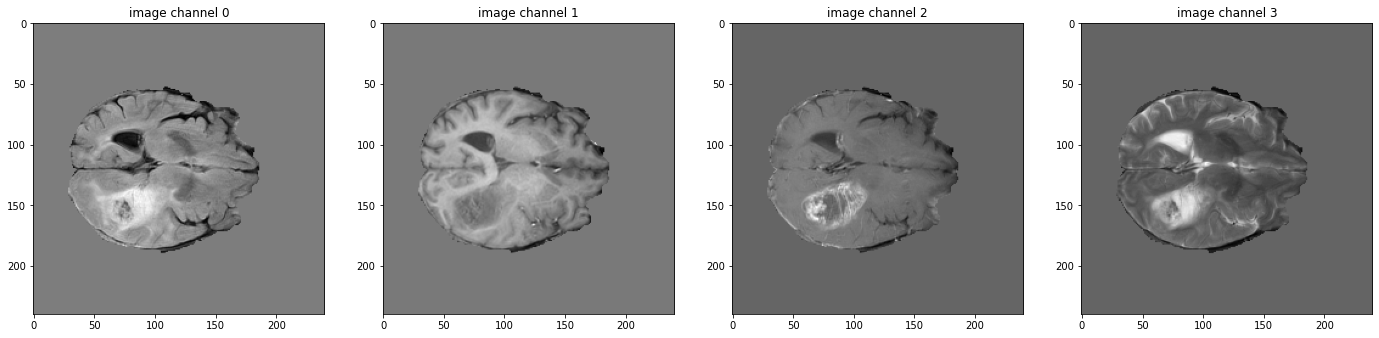

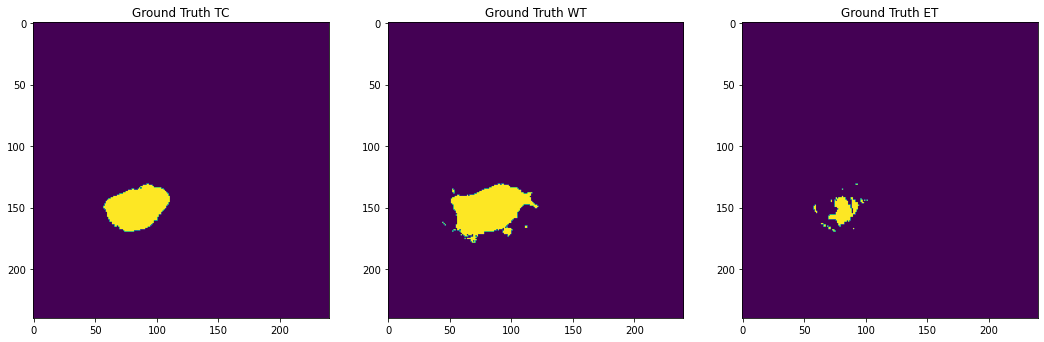

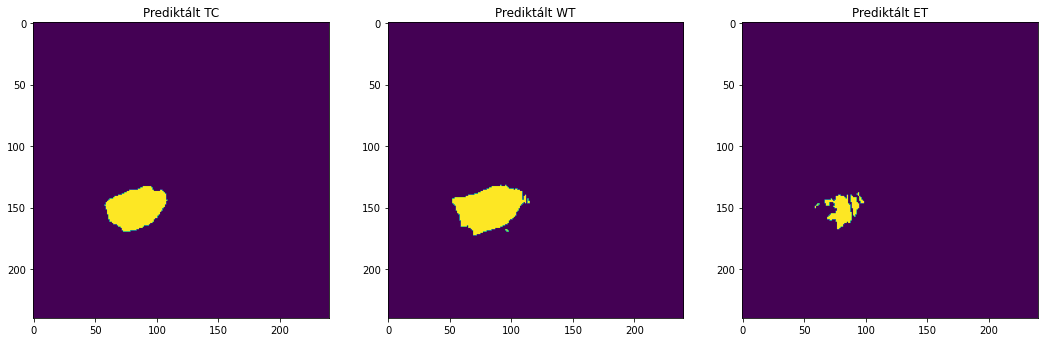

In [16]:
if cfg.arch == "ResNetVAE" or cfg.arch == "SegNetVAE":
    model.inference = True
    
#model_name = "shared/models/best_resnet3d_none_cosine.pth"
"""
model.load_state_dict(
    torch.load(model_name)['model_state']
)
"""
import nibabel as nib
from monai.metrics import get_confusion_matrix
model.eval()


labels = ["TC", "WT", "ET"]
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(cfg.device)
    roi_size = (128, 128, 128)
    sw_batch_size = 1
    val_output = inference(val_input, model)
    val_output = post_trans(val_output[0])
    #val_save = nib.Nifti1Image(val_output.astype(np.uint8), np.eye(4))
    #nib.save(val_save, 'mask_CC_part.nii.gz')
    #val_output = np.expand_dims(val_output, axis=0)
    #confusion_matrix = get_confusion_matrix(val_ds[6]["label"].unsqueeze(0).to(cfg.device), val_output)
    #print(confusion_matrix)
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
        #Log image to wandb
        wandb.log({"Input Image": [wandb.Image(val_ds[6]["image"][i, :, :, 70].detach().cpu(),\
             caption=f"image channel {i}")]})
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"Ground Truth {labels[i]}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
        #Log image to wandb
        wandb.log({"Ground Truth": [wandb.Image(val_ds[6]["label"][i, :, :, 70].detach().cpu(),\
                    caption=f"image channel {i}")]})
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"Prediktált {labels[i]}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
        
        #Log image to wandb
        wandb.log({"Predicted Label": [wandb.Image(val_output[i, :, :, 70].detach().cpu(),\
             caption=f"image channel {i}")]})
    plt.show()

In [ ]:
model.to("cuda")

# Postproccessing for Inference 🎬

In [ ]:
from utils import ConvertToMultiChannelBasedOnBratsClassesd
from monai.transforms import LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, NormalizeIntensityd, Activationsd, AsDiscreted,Invertd
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, .77, .77), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
        device="cpu",
    ),
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5),
])

# Inference on Test Dataset ✅

In [ ]:
VAL_AMP = True
#model.load_state_dict(torch.load(model_name)["model_state"])
model.to("cuda")
model.eval()
with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"]
        val_data["pred"] = inference(val_inputs, model)
        #val_data["pred"] = np.round(val_data["pred"])
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

#run.finish()

In [ ]:
val_input = val_ds[6]["image"].unsqueeze(0).to(cfg.device)
val_output = inference(val_input, model)